In [6]:
import time
timestamp_start = time.time()

# Training
Train `Doc2Vec` on both the training and the test data building a word → document inverted index. The training data are diverse English data sets.

In [7]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
import pickle
import gzip

TRAINING_FNAME="SemEval-2014_Task-3/data/training/paragraph2sentence.train.input.tsv"
OTHER_TRAINING_FNAMES=[]
TEST_FNAME="SemEval-2014_Task-3/data/test/paragraph2sentence.test.input.tsv"
TEST_GOLD_SCORE_FNAME="SemEval-2014_Task-3/keys/test/paragraph2sentence.test.gs.tsv"
NOTEBOOK_FNAME="untrained_pagerank"
MODEL_FNAME="untrained"

debug_file = open(NOTEBOOK_FNAME + ".log", 'w')
def debug(message):
    print(message, end='')
    debug_file.write(message)
    debug_file.flush()

buffers = {} # buffer files into RAM
for fname in OTHER_TRAINING_FNAMES:
    debug("Reading %s into RAM..." % fname) # print progress
    buffer = []
    with open(fname) as f:
        for doc in f:
            buffer.append(doc)
    buffers[fname] = buffer
    debug(" DONE\n") # print progress

In [8]:
wnl = WordNetLemmatizer()
inverted_index_serials = {}

def preprocess_document(doc, tag):
    for serial, w in enumerate(simple_preprocess(doc)):
        lemma = wnl.lemmatize(w)
        if lemma not in inverted_index:
            inverted_index[lemma] = {}
        if tag not in inverted_index[lemma]:
            if lemma not in inverted_index_serials:
                inverted_index_serials[lemma] = 0
            inverted_index[lemma][tag] = inverted_index_serials[lemma]
            inverted_index_serials[lemma] = inverted_index_serials[lemma] + 1
        yield lemma
        
class DocumentIterator(object):
    def __init__(self):
        self.epoch_number = 1
    def __iter__(self):
        debug(" Epoch %d: " % self.epoch_number) # print progress
        self.epoch_number = self.epoch_number + 1
        with open(TRAINING_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("training-" + cols[2] + "-paragraph", "training-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])
        doc_number = 1
        for fname in OTHER_TRAINING_FNAMES:
            debug(".") # print progress
            for doc in buffers[fname]:
                tag = str(doc_number)
                doc_number = doc_number + 1
                yield TaggedDocument(words=list(preprocess_document(doc, tag)), tags=[tag])
        with open(TEST_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])

inverted_index_loaded = False
try:
    with gzip.open(NOTEBOOK_FNAME + ".index", "rb") as f: # (a) load the entire inverted index
        inverted_index = pickle.load(f)
    model = Doc2Vec.load(MODEL_FNAME + ".doc2vec")
    inverted_index_loaded = True
except IOError:
    try:
        with gzip.open(MODEL_FNAME + ".index", "rb") as f: # (b) load the partially constructed inverted index
            inverted_index = pickle.load(f)
            model = Doc2Vec.load(MODEL_FNAME + ".doc2vec")
    except IOError:
        inverted_index = {}
        model = Doc2Vec(DocumentIterator(), dm=1, iter=100, size=100, workers=16) # (c) construct the inverted index
        model.save(MODEL_FNAME + ".doc2vec") # persist the model
        with gzip.open(MODEL_FNAME + ".index", "wb") as f: # persist the partially constructed inverted index
            pickle.dump(inverted_index, f, protocol=2)

For each word $w$, cluster the normalized vectors of documents containing $w$ via $k$-means, where $k$ is the cardinality of $w$'s synset according to WordNet. Store the vectors of the $k$ cluster centroids inside the inverted index entry for $w$.

In [9]:
import numpy as np

def l2_normalize(vec):
    norm = np.linalg.norm(vec)
    if norm == 0:
        return vec
    else:
        return vec / norm

In [10]:
from nltk.corpus import wordnet
from sklearn.cluster import k_means

if not inverted_index_loaded:
    for word, doc_tags in inverted_index.items():
        doc_vecs = [l2_normalize(model.docvecs[tag]) for tag in doc_tags if tag != "_centroid_vecs"]
        n = len(doc_vecs)
        if n > 100000: # skip words occuring in too many documents (would result in too large adj_matrix)
            debug("Skipped %s (too frequent), " % word)
            continue
        k = min(len(wordnet.synsets(word)), n)
        if k < 2: # skip unambiguous words
            continue
        doc_tags["_centroid_vecs"], _, _ = k_means(doc_vecs, n_clusters=k)
debug("\n")

For each word $w$ and each centroid $c$ of those documents $D$ that $w$ occurs in, create an adjacency matrix $m\in\mathbb{R}^{|D|\times|D|}$ and for every tuple of normalized document vectors $(u, v)$, set $m_{uv}$ to the cosine distance between $c-u$ and $c-v$, if $v$ is located between $u$ and $c$, or to zero otherwise. Run the PageRank algorithm on $m$ and interpret the resulting document ranks as probabilities that the occurance of $w$ in a given document $d$ has the sense represented by the centroid $c$. At the end, turn the soft clustering into a flat clustering by assigning each document to the centroid with the maximum associated rank.

[Despite all that is going on, notice that the time complexity is $O(WC(V\cdot N^2 + P\cdot N^2))$ where $W$ is the number of words, $C$ is the number of centroids, $V$ is the vector dimension, $P$ is the number of PageRank iterations and $N$ is the number of documents. Since $W, C, V, $ and $P$ can be bounded by constants (although quite large in the case of $W$), the time complexity is just $O(N^2)$. Less favourable is the fact that the space complexity is also $O(N^2)$ due to the need to hold the adjacency matrix $m$ in memory.]

In [11]:
import scipy.spatial

def pagerank(adj_matrix, source=None, damping=0.85, epsilon=1.0e-8):
    if source is None:
        n = len(adj_matrix)
        source = np.ones(n) / n
    ranks = source
    delta = np.float_("inf")
    while delta > epsilon:
        newranks = damping * np.dot(adj_matrix, ranks) + (1 - damping) * source
        delta = np.linalg.norm(ranks - newranks)
        ranks = newranks
    return ranks

def cosine_similarity(vec1, vec2): # cosine similarity clamped to [0; 2]
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0
    else:
        return 2.0 - scipy.spatial.distance.cosine(vec1, vec2)

def l1_normalize(arr):
    norm = np.sum(arr)
    if norm == 0:
        return arr
    else:
        return arr / norm

if not inverted_index_loaded:
    precomputed_docvec_distances = np.zeros((len(model.docvecs), len(model.docvecs)))
    word_index = 1
    for word, doc_tags in inverted_index.items():
        if word_index % 500 == 0: # print progress
            debug("\n%f %%" % (word_index * 100.0 / len(inverted_index)))
        word_index = word_index + 1
        if "_centroid_vecs" not in inverted_index[word]:
            continue
        doc_vecs = np.array([l2_normalize(model.docvecs[tag]) for tag in doc_tags if \
                             tag != "_centroid_vecs" and tag != "_best_centroids"])
        doc_serials = [doc_tags[tag] for tag in doc_tags if \
                       tag != "_centroid_vecs" and tag != "_best_centroids"]
        best_centroids = [{"rank": 0.0, "index": 0} for doc_vec in doc_vecs]
        for u_index, u_serial in enumerate(doc_serials): # precompute vector distances
            for v_index, v_serial in enumerate(doc_serials):
                if u_index == v_index:
                    continue # leave zeroes on the diagonal
                if precomputed_docvec_distances[u_serial][v_serial] == 0.0:
                    u_vec = doc_vecs[u_index]
                    v_vec = doc_vecs[v_index]
                    precomputed_docvec_distances[u_serial][v_serial] = scipy.spatial.distance.cosine(u_vec, v_vec)
        for centroid_index, centroid_vec in enumerate(doc_tags["_centroid_vecs"]):
            precomputed_centroid_distances = np.zeros(len(model.docvecs))
            for u_index, u_serial in enumerate(doc_serials): # precompute centroid distances
                if precomputed_centroid_distances[u_serial] == 0.0:
                    u_vec = doc_vecs[u_index]
                    precomputed_centroid_distances[u_serial] = scipy.spatial.distance.cosine(u_vec, centroid_vec)
            precomputed_centroid_subtractions = [None] * len(model.docvecs)
            for u_index, u_serial in enumerate(doc_serials): # precompute centroid subtractions
                if precomputed_centroid_subtractions[u_serial] == None:
                    u_vec = doc_vecs[u_index]
                    precomputed_centroid_subtractions[u_serial] = centroid_vec - u_vec
            adj_matrix = np.zeros((len(doc_vecs), len(doc_vecs)))
            for u_index, u_vec in enumerate(doc_vecs):
                for v_index, v_vec in enumerate(doc_vecs):
                    if u_index == v_index:
                        continue # leave zeroes on the diagonal
                    u_serial = doc_serials[u_index]
                    v_serial = doc_serials[v_index]
                    uv_dist = precomputed_docvec_distances[u_serial][v_serial]
                    uc_dist = precomputed_centroid_distances[u_serial]
                    vc_dist = precomputed_centroid_distances[v_serial]
                    if uv_dist < uc_dist and uc_dist > vc_dist: # v is between u and c
                        adj_matrix[u_index, v_index] = cosine_similarity(
                            precomputed_centroid_subtractions[u_serial],
                            precomputed_centroid_subtractions[v_serial])
                adj_matrix[u_index] = l1_normalize(adj_matrix[u_index]) # rows must add up to 1
            for doc_index, rank in enumerate(l1_normalize(pagerank(adj_matrix.transpose()))):
                if rank > best_centroids[doc_serials[doc_index]]["rank"]:
                    best_centroids[doc_serials[doc_index]]["rank"] = rank
                    best_centroids[doc_serials[doc_index]]["index"] = centroid_index
        doc_tags["_best_centroids"] = best_centroids
        
    with gzip.open(NOTEBOOK_FNAME + ".index", "wb") as f: # persist the inverted index
        pickle.dump(inverted_index, f, protocol=2)


4.765081 %
9.530163 %
14.295244 %
19.060326 %
23.825407 %
28.590489 %
33.355570 %
38.120652 %
42.885733 %
47.650815 %
52.415896 %
57.180978 %
61.946059 %
66.711141 %
71.476222 %
76.241304 %
81.006385 %
85.771467 %
90.536548 %
95.301630 %

For each document $d$ and an occurance of word $w$ in $d$, label this occurance of $w$ with the index $i$, where $c_i$ is the centroid assigned to the occurance of $w$ in $d$. Train `Doc2Vec` on the disambiguated training data.

In [12]:
def preprocess_document(doc, tag):
    for w in simple_preprocess(doc):
        lemma = wnl.lemmatize(w)
        if lemma in inverted_index and "_best_centroids" in inverted_index[lemma]:
            yield lemma + "-" + str(inverted_index[lemma]["_best_centroids"][inverted_index[lemma][tag]]["index"])
        else:
            yield lemma
        
class DocumentIterator(object):
    def __init__(self):
        self.epoch_number = 1
    def __iter__(self):
        debug(" Epoch %d: " % self.epoch_number) # print progress
        self.epoch_number = self.epoch_number + 1
        with open(TRAINING_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("training-" + cols[2] + "-paragraph", "training-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])
        doc_number = 1
        for fname in OTHER_TRAINING_FNAMES:
            debug(".") # print progress
            for doc in buffers[fname]:
                tag = str(doc_number)
                doc_number = doc_number + 1
                yield TaggedDocument(words=list(preprocess_document(doc, tag)), tags=[tag])
        with open(TEST_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])

try:
    disambiguated_model = Doc2Vec.load(NOTEBOOK_FNAME + ".doc2vec")
except IOError:
    disambiguated_model = Doc2Vec(DocumentIterator(), dm=1, iter=100, size=100)
    disambiguated_model.save(NOTEBOOK_FNAME + ".doc2vec") # persist the model

 Epoch 1:  Epoch 2:  Epoch 3:  Epoch 4:  Epoch 5:  Epoch 6:  Epoch 7:  Epoch 8:  Epoch 9:  Epoch 10:  Epoch 11:  Epoch 12:  Epoch 13:  Epoch 14:  Epoch 15:  Epoch 16:  Epoch 17:  Epoch 18:  Epoch 19:  Epoch 20:  Epoch 21:  Epoch 22:  Epoch 23:  Epoch 24:  Epoch 25:  Epoch 26:  Epoch 27:  Epoch 28:  Epoch 29:  Epoch 30:  Epoch 31:  Epoch 32:  Epoch 33:  Epoch 34:  Epoch 35:  Epoch 36:  Epoch 37:  Epoch 38:  Epoch 39:  Epoch 40:  Epoch 41:  Epoch 42:  Epoch 43:  Epoch 44:  Epoch 45:  Epoch 46:  Epoch 47:  Epoch 48:  Epoch 49:  Epoch 50:  Epoch 51:  Epoch 52:  Epoch 53:  Epoch 54:  Epoch 55:  Epoch 56:  Epoch 57:  Epoch 58:  Epoch 59:  Epoch 60:  Epoch 61:  Epoch 62:  Epoch 63:  Epoch 64:  Epoch 65:  Epoch 66:  Epoch 67:  Epoch 68:  Epoch 69:  Epoch 70:  Epoch 71:  Epoch 72:  Epoch 73:  Epoch 74:  Epoch 75:  Epoch 76:  Epoch 77:  Epoch 78:  Epoch 79:  Epoch 80:  Epoch 81:  Epoch 82:  Epoch 83:  Epoch 84:  Epoch 85:  Epoch 86:  Epoch 87:  Epoch 88:  Epoch 89:  Epoch 90:  Epoch 91:  Epoch 9

# Testing
Compute the cosine similarity of the disambiguated document vectors of the testing paragraph-sentence pairs.

In [13]:
test_similarities = []
with open(TEST_FNAME) as f:
    for row in f:
        cols = row.rstrip().split("\t")
        tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
        disambiguated_vec1 = disambiguated_model.docvecs[tags[0]]
        disambiguated_vec2 = disambiguated_model.docvecs[tags[1]]
        test_similarities.append(cosine_similarity(disambiguated_vec1, disambiguated_vec2) * 2.0)

Compare the similarities with the gold score.

<IPython.core.display.Javascript object>


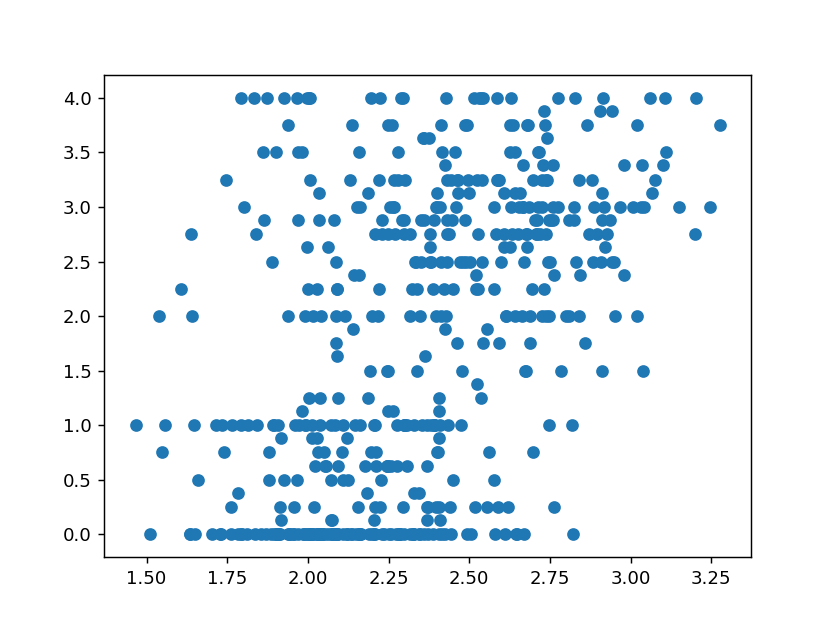

Pearson's correlation coefficient: 0.469074


In [14]:
%matplotlib notebook
import scipy.stats
import matplotlib.pyplot as plt

test_gold_similarities = []
with open(TEST_GOLD_SCORE_FNAME) as f:
    for line in f:
        test_gold_similarities.append(float(line))

plt.scatter(test_similarities, test_gold_similarities)
plt.show()
debug("Pearson's correlation coefficient: %f\n" % scipy.stats.pearsonr(test_similarities, test_gold_similarities)[0])

In [15]:
timestamp_end = time.time()
debug("Time elapsed: %d seconds\n" % (timestamp_end - timestamp_start))

Time elapsed: 858 seconds
